In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



In [6]:
spark = SparkSession.builder.appName("Bank").getOrCreate()

data = spark.read.csv(path='bank.csv',
                         sep=',',
                         encoding='UTF-8',
                         comment=None,
                         header=True,
                         inferSchema=True)

In [7]:
data.show(n=5, truncate=False)


+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|59 |admin.    |married|secondary|no     |2343   |yes    |no  |unknown|5  |may  |1042    |1       |-1   |0       |unknown |yes    |
|56 |admin.    |married|secondary|no     |45     |no     |no  |unknown|5  |may  |1467    |1       |-1   |0       |unknown |yes    |
|41 |technician|married|secondary|no     |1270   |yes    |no  |unknown|5  |may  |1389    |1       |-1   |0       |unknown |yes    |
|55 |services  |married|secondary|no     |2476   |yes    |no  |unknown|5  |may  |579     |1       |-1   |0       |unknown |yes    |
|54 |admin.    |married|tertiary |no     |184    |no     |no  |unknown|5  |m

In [8]:
print(len(data.columns), data.count())


17 11162


In [9]:
data.printSchema()


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [10]:
def find_missing_values_columns(df):
    nrow = df.count()
    for v in df.columns:
        summary_df = df.select(v).describe()
        v_count = int(summary_df.collect()[0][v])
        if v_count < nrow:
            missing_percentage = (1 - v_count/nrow) * 100
            print( #"Total observations: " + str(nrow) + "\n"
                 #"Total observations of " + v + ": " + str(v_count) + "\n"
                 "Percentage of missing values: " + str(missing_percentage) + "%" + "\n"
                 "----------------------------")


In [11]:
find_missing_values_columns(data)


In [12]:
data.groupBy("deposit").count().show()


+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



### Transform string data

In [13]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

In [14]:
label_string_indexer = StringIndexer(inputCol = 'deposit', outputCol = 'label')

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']


In [15]:
indexers = [
    StringIndexer(inputCol=col, outputCol="{0}_indexed".format(col))
    for col in categorical_columns
]

encoders = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers],
                         outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers])

numericCols = ['age', 'balance', 'campaign', 'pdays', 'previous']

assembler_inputs = [out_col for out_col in encoders.getOutputCols()] + numericCols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

all_stages = indexers + [encoders] + [assembler] + [label_string_indexer]

pipeline = Pipeline(stages=all_stages)
pipelineModel = pipeline.fit(data)




In [16]:
data_updated = pipelineModel.transform(data)

In [17]:
final_columns = data.columns + ['features', 'label']
data_df = pipelineModel.transform(data).\
            select(final_columns)
            
data_df.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+--------------------+-----+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|            features|label|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+--------------------+-----+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|(29,[3,11,13,16,1...|  1.0|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|(29,[3,11,13,16,1...|  1.0|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|(29,[2,11,13,16,1...|  1.0|
| 55|  services|married|secondary|     no|   2

In [18]:
data_df.groupBy("label", 'deposit').count().show()


+-----+-------+-----+
|label|deposit|count|
+-----+-------+-----+
|  0.0|     no| 5873|
|  1.0|    yes| 5289|
+-----+-------+-----+



### DecisionTreeClassifier

In [32]:
def plot(predictions):
    actual = predictions.select(['label']).collect()
    predicted = predictions.select(['prediction']).collect()
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
    cm_display.plot()
    plt.show()

In [20]:
train, test = data_df.randomSplit([0.8, 0.2], seed=1234)
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth = 3)
dtModel = dt.fit(train)
dt_predictions = dtModel.transform(test)
dt_predictions.select('features', 'rawPrediction', 'probability', 'prediction', 'label').show(10)


+--------------------+---------------+--------------------+----------+-----+
|            features|  rawPrediction|         probability|prediction|label|
+--------------------+---------------+--------------------+----------+-----+
|(29,[7,12,15,16,1...|   [68.0,778.0]|[0.08037825059101...|       1.0|  1.0|
|(29,[7,12,16,17,1...|[1579.0,2005.0]|[0.44056919642857...|       1.0|  1.0|
|(29,[3,12,13,16,1...|[1579.0,2005.0]|[0.44056919642857...|       1.0|  0.0|
|(29,[7,11,16,17,1...|[1579.0,2005.0]|[0.44056919642857...|       1.0|  1.0|
|(29,[7,12,15,16,1...|[1579.0,2005.0]|[0.44056919642857...|       1.0|  0.0|
|(29,[7,12,15,16,1...|[1579.0,2005.0]|[0.44056919642857...|       1.0|  0.0|
|(29,[7,12,15,16,1...|[1579.0,2005.0]|[0.44056919642857...|       1.0|  1.0|
|(29,[7,12,16,17,1...|[1579.0,2005.0]|[0.44056919642857...|       1.0|  1.0|
|(29,[1,12,13,16,1...|   [68.0,778.0]|[0.08037825059101...|       1.0|  0.0|
|(29,[0,12,14,16,1...|[1579.0,2005.0]|[0.44056919642857...|       1.0|  0.0|

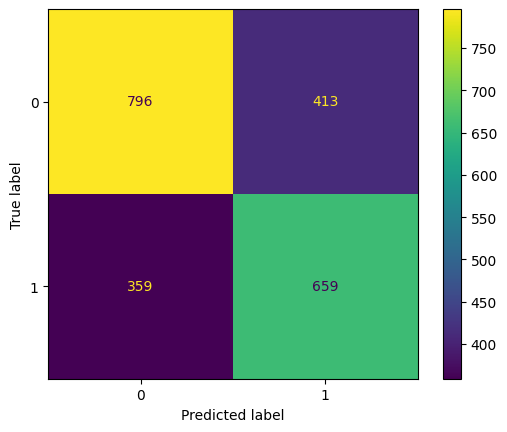

In [34]:
plot(dt_predictions)

In [36]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
accuracy = evaluator.evaluate(dt_predictions)
accuracy

0.6533453075886844

### LogisticRegression

In [37]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label')
lr_model = lr.fit(train)
lr_predictions = lr_model.transform(test)
lr_predictions.select('features', 'rawPrediction', 'probability', 'prediction', 'label').show(10)
accuracy = evaluator.evaluate(lr_predictions)
accuracy

+--------------------+--------------------+--------------------+----------+-----+
|            features|       rawPrediction|         probability|prediction|label|
+--------------------+--------------------+--------------------+----------+-----+
|(29,[7,12,15,16,1...|[-3.1199923242656...|[0.04229008272070...|       1.0|  1.0|
|(29,[7,12,16,17,1...|[-0.9976553158369...|[0.26940266392730...|       1.0|  1.0|
|(29,[3,12,13,16,1...|[-0.1441618014758...|[0.46402183811283...|       1.0|  0.0|
|(29,[7,11,16,17,1...|[-0.7307832228538...|[0.32502287809052...|       1.0|  1.0|
|(29,[7,12,15,16,1...|[-0.6438861224187...|[0.34436860519730...|       1.0|  0.0|
|(29,[7,12,15,16,1...|[-1.2563078751444...|[0.22161012567774...|       1.0|  0.0|
|(29,[7,12,15,16,1...|[-1.0267137773510...|[0.26372170280607...|       1.0|  1.0|
|(29,[7,12,16,17,1...|[-1.0218543484514...|[0.26466635335379...|       1.0|  1.0|
|(29,[1,12,13,16,1...|[-2.4398795518962...|[0.08018179509345...|       1.0|  0.0|
|(29,[0,12,14,16

0.6811854512797485

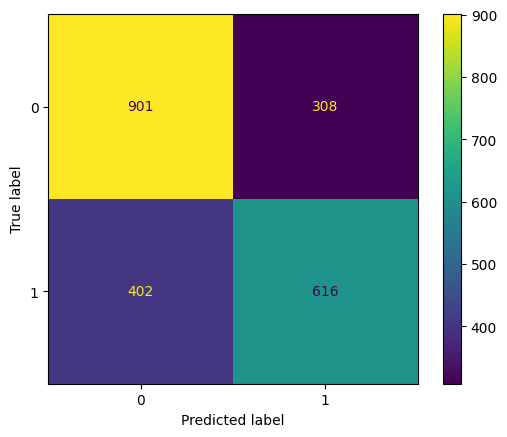

In [38]:
plot(lr_predictions)

### Random forest

In [23]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label',  numTrees=10)
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)
rf_predictions.select('features', 'rawPrediction', 'probability', 'prediction', 'label').show(10)
accuracy = evaluator.evaluate(rf_predictions)


+--------------------+--------------------+--------------------+----------+-----+
|            features|       rawPrediction|         probability|prediction|label|
+--------------------+--------------------+--------------------+----------+-----+
|(29,[7,12,15,16,1...|[1.72835138967643...|[0.17283513896764...|       1.0|  1.0|
|(29,[7,12,16,17,1...|[4.20673404201495...|[0.42067340420149...|       1.0|  1.0|
|(29,[3,12,13,16,1...|[4.22318909179206...|[0.42231890917920...|       1.0|  0.0|
|(29,[7,11,16,17,1...|[3.04698746987021...|[0.30469874698702...|       1.0|  1.0|
|(29,[7,12,15,16,1...|[4.60081897843985...|[0.46008189784398...|       1.0|  0.0|
|(29,[7,12,15,16,1...|[3.47253677792711...|[0.34725367779271...|       1.0|  0.0|
|(29,[7,12,15,16,1...|[3.8089996807723,...|[0.38089996807723...|       1.0|  1.0|
|(29,[7,12,16,17,1...|[3.8089996807723,...|[0.38089996807723...|       1.0|  1.0|
|(29,[1,12,13,16,1...|[1.55935825757173...|[0.15593582575717...|       1.0|  0.0|
|(29,[0,12,14,16

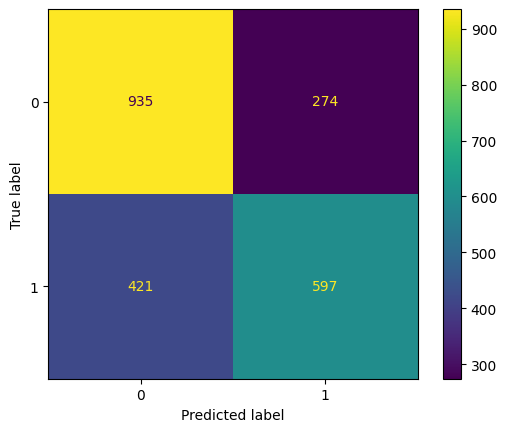

In [33]:
plot(rf_predictions)

### Linear Support Vector Machine

In [25]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=10, regParam=0.1)
lsvc_model= lsvc.fit(train)
lsvc_predictions = lsvc_model.transform(test)
lsvc_accuracy = evaluator.evaluate(lsvc_predictions)


In [26]:
dt_accuracy = evaluator.evaluate(dt_predictions)
lr_accuracy = evaluator.evaluate(lr_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)
lsvc_accuracy = evaluator.evaluate(lsvc_predictions)


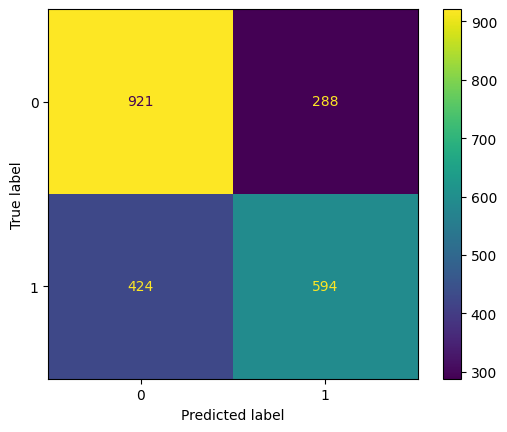

In [39]:
plot(lsvc_predictions)

In [31]:
print("DecisionTreeClassifier:", dt_accuracy, "\n"+ "Logistic Regression:", lr_accuracy,   "\n"+
      "Random Forest:", rf_accuracy,  "\n"+ "Linear Support Vector Machine:", lsvc_accuracy)

DecisionTreeClassifier: 0.6533453075886844 
Logistic Regression: 0.6811854512797485 
Random Forest: 0.6879209699146834 
Linear Support Vector Machine: 0.6802873821284239


In [23]:
spark.stop()